## The `jumpFromMean` feature

### To run this notebook, please [follow the instructions](https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html) or else it won`t work.
The instructions are at https://lasair-lsst.readthedocs.io/en/main/core_functions/python-notebooks.html

This simple feature is to filter out lightcurves with a significant change in brightness. 
For each waveband, it goes back from the latest diaSource from 70 days ago to 10 days ago, and finds
the mean and standard deviation. Then asks how many sigma is the latest point
of that band from the mean. The greatest deviation becomes `jump1`, and second greatest `jump2`.

In [7]:
import json, sys, random
import math, numpy as np
from IPython.display import Image, display

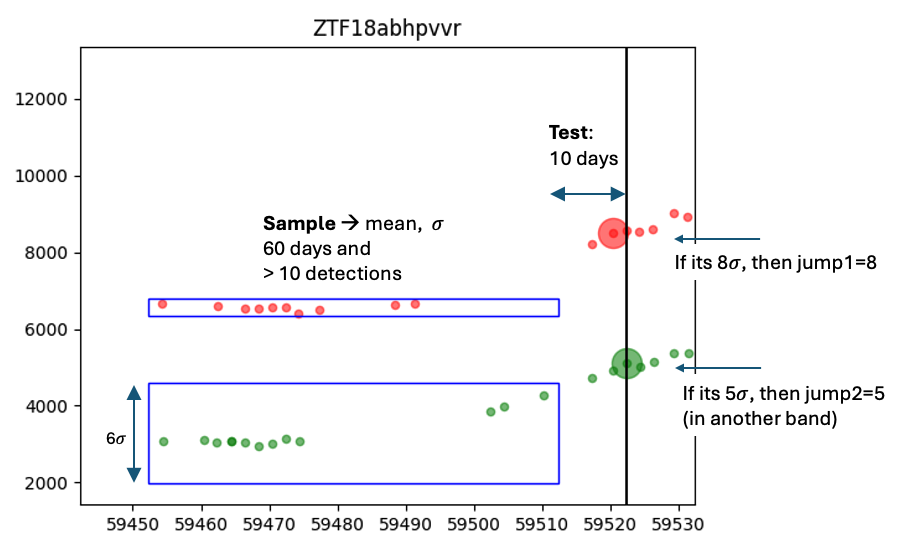

In [8]:
display(Image(filename="image/jump_image.png"))

In [9]:
n_sample = 5     # must be this many of given band in sample interval
t_sample = 60     # length of sample interval in days
t_test   = 10     # length of test interval in days

In [10]:
def run(lc_flux, lc_time, lc_band):
        fluxsum  = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':0 } 
        fluxsum2 = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':0 } 
        n        = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':0 }
        fluxmean = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':0 } 
        fluxsd   = {'u':0, 'g':0, 'r':0, 'i':0, 'z':0, 'y':0 } 
        max_jump = {'u':0.0, 'g':0.0, 'r':0.0, 'i':0.0, 'z':0.0, 'y':0.0 } 

        T = max(lc_time)   # last diaSource we know about
        print('Evaluating at T=', T)

        for k in range(len(lc_time)):        # look back for sample
            delta = T - lc_time[k]
            # is it in the sample space
            if delta > t_test and delta < t_test + t_sample:
                f = lc_flux[k]
                band = lc_band[k]
                n[band] += 1
                fluxsum[band]  += f
                fluxsum2[band] += f*f

        for band in n.keys():
            m = n[band]
            if m < n_sample:  # enough in the sample period
                continue
            fluxmean[band] = fluxsum[band]/m
            fluxsd[band]   = math.sqrt((fluxsum2[band] - m*fluxmean[band]*fluxmean[band])/(m-1))
        print('Means:', fluxmean)
        print('Stddev:', fluxsd)
    
        for k in range(len(lc_time)):        # look back for test
            delta = T - lc_time[k]
            # is it in the test space
            if delta > 0 and delta < t_test:
                band = lc_band[k]
                if n[band] < n_sample:  # enough in the sample period
                    continue
                jmp = abs(lc_flux[k] - fluxmean[band])/fluxsd[band]
                if jmp > max_jump[band]:
                    max_jump[band] = jmp
        jumps = list(max_jump.values())
        jumps.sort()
        out = { 
            "jump1": jumps[-1], 
            "jump2": jumps[-2], 
        } 
        return out

### Fetch the lightcurves of the found objects

In [11]:
lc_fluxg = [ 3000, 3010, 3020, 3010, 3040, 3020, 3010, 3040, 2990, 3200, 3250, 3299,    4400, 4500]
lc_timeg = [59455,59457,59459,59465,59467,59469,59475,59477,59479,59500,59505,59510,   59520,59522]
lc_bandg = ['g']*len(lc_fluxg)

lc_fluxr = [ 6000, 6010, 6020, 6010, 6040, 6010, 6040, 6090, 6200, 6250, 6299,    8400, 8300]
lc_timer = [59455,59457,59459,59465,59467,59475,59477,59479,59500,59505,59509,   59518,59520]
lc_bandr = ['r']*len(lc_fluxr)

lc_flux = lc_fluxg+lc_fluxr
lc_time = lc_timeg+lc_timer
lc_band = lc_bandg+lc_bandr
out = run(lc_flux, lc_time, lc_band)
print(out)

Evaluating at T= 59522
Means: {'u': 0, 'g': 3074.0833333333335, 'r': 6088.090909090909, 'i': 0, 'z': 0, 'y': 0}
Stddev: {'u': 0, 'g': 108.8956617662717, 'r': 108.87649383174322, 'i': 0, 'z': 0, 'y': 0}
{'jump1': 21.23423532063675, 'jump2': 12.176028366607927}
